# Movie Analysis for Microsoft

**Author:** Benjamin Dean
***

## Project Overview

Students were given a scenario in which Microsoft has decided to begin their own movie studio and is looking for advice on how to do so. This project begins with exploratory data analysis and determines profit and ratings to be the target dependant variables. Data is then cleaned, merged, and modeled. Visualizations were made comparing different variables to the target variables. Finally, analysis suggests Microsoft take a number of actions in reference to genres, directors, and production budgets in order to build a successful movie portfolio

### Business Problem

## Data Understanding

We perform exploratory data analysis on six dataframes provided by Contain movies from the 

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_rows', 100)

#### Import datasets

In [2]:
ratings = pd.read_csv('data/zippedData/imdb.title.ratings.csv.gz')
basics = pd.read_csv('data/zippedData/imdb.title.basics.csv.gz')
directors = pd.read_csv('data/zippedData/imdb.title.crew.csv.gz')
names = pd.read_csv('data/zippedData/imdb.name.basics.csv.gz')
releases = pd.read_csv('data/zippedData/tmdb.movies.csv.gz')
budgets = pd.read_csv('data/zippedData/tn.movie_budgets.csv.gz')

## Data Preparation

#### Remove unwanted columns and rows

In [3]:
ratings = ratings.drop(ratings[ratings.numvotes < 100].index)
names = names[names['primary_profession'].str.contains('director', na=False)]
names.drop(columns = ['birth_year', 'death_year', 'known_for_titles'], inplace=True)
basics.drop(columns = ['original_title', 'runtime_minutes'], inplace=True)
directors.drop(columns = 'writers', inplace=True)
releases.drop(columns = ['genre_ids', 'id', 'original_language', 'popularity',\
                         'original_title', 'vote_average', 'vote_count'], inplace=True)

#### Rename columns to allow for dataset merging

In [4]:
directors.rename(columns={'directors': 'nconst'}, inplace=True)
releases.rename(columns={'title': 'primary_title'}, inplace=True)
budgets.rename(columns={'movie': 'primary_title'}, inplace=True)

In [5]:
releases.release_date = pd.to_datetime(releases.release_date)
budgets.release_date = pd.to_datetime(budgets.release_date)

#### Merge datasets

In [6]:
genres_by_ratings = pd.merge(ratings, basics, on='tconst')\
                      .merge(directors, on='tconst')\
                      .merge(names, on='nconst')\
                      .merge(releases, on='primary_title' )\
                      .merge(budgets, on=['primary_title', 'release_date'])

#### Remove unwanted characters in order to make values convertable to intergers

In [7]:
series_list = ['production_budget', 'domestic_gross', 'worldwide_gross']
for series in series_list:
    for symbol in ['$', ',']:
        genres_by_ratings[series] = genres_by_ratings[series].str.replace(symbol,'')
    genres_by_ratings[series] = pd.to_numeric(genres_by_ratings[series])

#### Add profit column

In [8]:
genres_by_ratings['profit'] = genres_by_ratings['worldwide_gross'] - genres_by_ratings['production_budget']

In [9]:
budgets.rename(columns={'movie': 'primary_title'}, inplace=True)

In [10]:
genres_by_ratings = genres_by_ratings[genres_by_ratings.groupby('genres').genres.transform(len) >=3]
for_graph = genres_by_ratings.groupby('genres').mean()
for_graph = for_graph.loc[:,['production_budget', 'profit', 'worldwide_gross']]
for_graph.sort_values(by='profit', ascending=False, inplace=True)
for_graph = for_graph.head(25)
for_graph.head()

,production_budget,profit,worldwide_gross
genres,,,
"Adventure,Drama,Sci-Fi",1.270000e+08,5.319741e+08,6.589741e+08
"Action,Adventure,Sci-Fi",1.663886e+08,5.234292e+08,6.898177e+08
"Adventure,Fantasy",2.316667e+08,4.695440e+08,7.012107e+08
"Adventure,Family,Fantasy",1.606818e+08,3.744137e+08,5.350955e+08
"Action,Adventure,Comedy",1.102500e+08,3.537390e+08,4.639890e+08


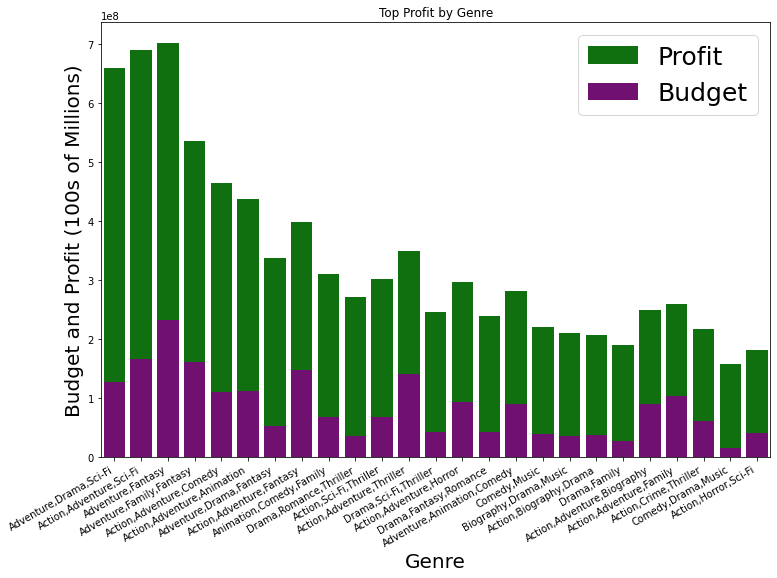

In [11]:
sns.set_context({'figure.figsize': (12,8)})
sns.barplot(x=for_graph.index, y=for_graph.worldwide_gross, color='green', label='Profit').set(title='Top Profit by Genre')
sns.barplot(x=for_graph.index, y=for_graph.production_budget, color='purple', label='Budget')
plt.xlabel('Genre', fontsize=20)
plt.ylabel("Budget and Profit (100s of Millions)", fontsize=20)
plt.xticks(rotation=30, ha='right')
plt.legend(prop={'size': 25});

In [12]:
second_graph = genres_by_ratings.groupby('primary_name').mean()
second_graph = second_graph.loc[:, ['averagerating', 'profit']]
second_graph.sort_values(by='profit', ascending=False, inplace=True)
second_graph = second_graph.head(25)

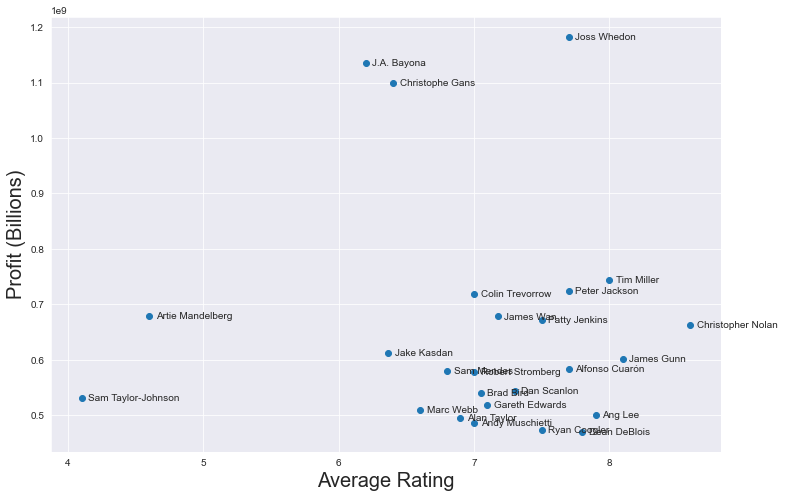

In [13]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
v = second_graph.averagerating
w = second_graph.profit
annotations = second_graph.index
plt.scatter(v,w)
plt.xlabel('Average Rating', fontsize=20)
plt.ylabel('Profit (Billions)', fontsize=20)
for i, label in enumerate(annotations):
    plt.annotate(label, (v.iloc[i]+.05, w.iloc[i]-5000000))
plt.show();

#### Ratings by Expenditure

In [14]:
genres_by_ratings.head()

,tconst,averagerating,numvotes,primary_title,start_year,genres,nconst,primary_name,primary_profession,release_date,id,production_budget,domestic_gross,worldwide_gross,profit
0,tt1043726,4.2,50352,The Legend of Hercules,2014,"Action,Adventure,Fantasy",nm0001317,Renny Harlin,"producer,director,writer",2014-01-10,42,70000000,18848538,58953319,-11046681
1,tt1171222,5.1,8296,Baggage Claim,2013,Comedy,nm0847859,David E. Talbert,"writer,director,producer",2013-09-27,38,8500000,21569509,22885836,14385836
2,tt4649416,6.1,5212,Almost Christmas,2016,"Comedy,Drama",nm0847859,David E. Talbert,"writer,director,producer",2016-11-11,81,17000000,42065185,42493506,25493506
3,tt2179136,7.3,401915,American Sniper,2014,"Action,Biography,Drama",nm0000142,Clint Eastwood,"actor,producer,director",2014-12-25,57,58000000,350126372,547326372,489326372
4,tt2179136,7.3,401915,American Sniper,2014,"Action,Biography,Drama",nm0000142,Clint Eastwood,"actor,producer,director",2014-12-25,57,58000000,350126372,547326372,489326372


In [47]:
third_graph = genres_by_ratings.loc[:, ['averagerating', 'production_budget', 'profit']]
third_graph['budget_grp'] = None
for element in range(len(third_graph.budget_grp)):
    if third_graph.production_budget.iloc[element] <= 25000000:
        third_graph.budget_grp.iloc[element] = '<=25'
    elif third_graph.production_budget.iloc[element] > 25000000 and third_graph.production_budget.iloc[element] <= 50000000:
        third_graph.budget_grp.iloc[element] = '<=50'
    elif third_graph.production_budget.iloc[element] > 50000000 and third_graph.production_budget.iloc[element] <= 75000000:
        third_graph.budget_grp.iloc[element] = '<=75'
    elif third_graph.production_budget.iloc[element] > 75000000 and third_graph.production_budget.iloc[element] <= 100000000:
        third_graph.budget_grp.iloc[element] = '<=100'
    elif third_graph.production_budget.iloc[element] > 100000000 and third_graph.production_budget.iloc[element] <= 125000000:
        third_graph.budget_grp.iloc[element] = '<=125'
    elif third_graph.production_budget.iloc[element] > 125000000 and third_graph.production_budget.iloc[element] <= 150000000:
        third_graph.budget_grp.iloc[element] = '<=150'
    elif third_graph.production_budget.iloc[element] > 150000000 and third_graph.production_budget.iloc[element] <= 175000000:
        third_graph.budget_grp.iloc[element] = '<=175'
    elif third_graph.production_budget.iloc[element] > 175000000 and third_graph.production_budget.iloc[element] <= 200000000:
        third_graph.budget_grp.iloc[element] = '<=200'
    else:
        third_graph.budget_grp.iloc[element] = '>200'

In [36]:
third_graph.averagerating.describe()

count    1084.000000
mean        6.334779
std         1.014056
min         2.100000
25%         5.775000
50%         6.400000
75%         7.100000
max         8.800000
Name: averagerating, dtype: float64

In [32]:
twentyfive_mil = third_graph.loc[third_graph['budget_grp'] == '<=25']
above_std = twentyfive_mil.averagerating.mean() + (twentyfive_mil.averagerating.std())*2
below_std = twentyfive_mil.averagerating.mean() - (twentyfive_mil.averagerating.std())*2

In [44]:
within_2_std = twentyfive_mil[(twentyfive_mil.averagerating <= above_std) & (twentyfive_mil.averagerating >= below_std)]

In [45]:
within_2_std.describe()

,averagerating,production_budget,profit
count,541.000000,5.410000e+02,5.410000e+02
mean,6.314233,1.104890e+07,2.604661e+07
std,0.938715,7.839194e+06,5.402531e+07
min,4.100000,3.000000e+04,-2.485385e+07
25%,5.700000,4.000000e+06,-1.493763e+06
50%,6.400000,1.000000e+07,7.618727e+06
75%,7.000000,1.800000e+07,3.104352e+07
max,8.300000,2.500000e+07,4.063512e+08


In [21]:
third_graph.budget_grp.value_counts()

<=25     563
<=50     232
<=75      85
<=100     56
<=150     38
<=125     33
<=200     31
<=175     25
>200      21
Name: budget_grp, dtype: int64

In [18]:
third_graph = third_graph.groupby('budget_grp').mean()

In [19]:
#plt.bar(t, u)
for symbol in ['<', '=', '>']:
    third_graph.index = third_graph.index.str.replace(symbol, '')
third_graph.index = pd.to_numeric(third_graph.index)
third_graph.sort_values(by='budget_grp')

,averagerating,production_budget,profit
budget_grp,,,
25,6.225222,1.100675e+07,2.618037e+07
50,6.418534,3.711422e+07,6.456653e+07
75,6.260000,6.169882e+07,1.138410e+08
100,6.092857,9.058929e+07,1.577862e+08
125,6.530303,1.145758e+08,2.558814e+08
150,6.573684,1.382632e+08,2.525694e+08
175,6.840000,1.656800e+08,4.380750e+08
200,7.077419,1.900323e+08,4.806583e+08
200,6.857143,2.603905e+08,6.378738e+08


<AxesSubplot:xlabel='budget_grp', ylabel='averagerating'>

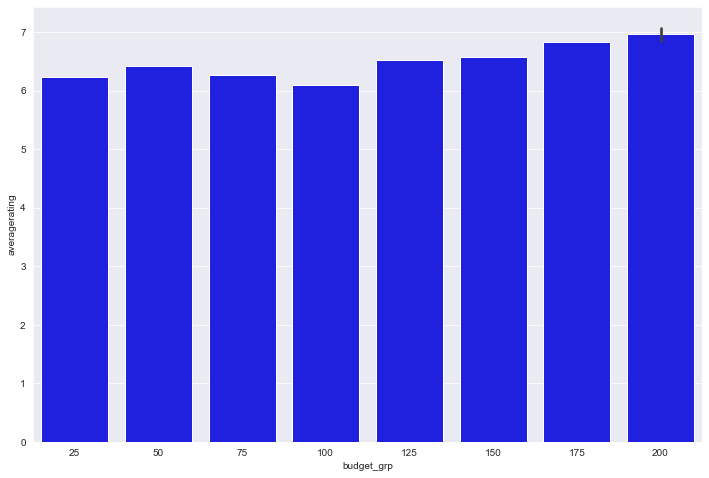

In [20]:
sns.set_context({'figure.figsize': (12,8)})
sns.barplot(x=third_graph.index, y=third_graph.averagerating, color='blue')